In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import constants, signal
from scipy.signal import hilbert, chirp
from scipy.fft import fft, fftfreq, fftshift

from pathlib import Path

In [2]:
def csv(filename: str, skiprows = 4):
    """Reads a csv file at a particular location, and extracts the sampling frequency by assuming the first column read in csv file is the time axis, in seconds

    Args:
        filename (std): the path to the file we want to analyze 
        skiprows (int, optional): the number of rows in the data file we want to skip. Defaults to 4.

    Returns:
        A pandas data frame containing the data, and the sampling frequency  
    """
    df = pd.read_csv(filename, delimiter=",", skiprows = skiprows, header=None)
    t = df.iloc[:,0].to_numpy()
    
    # compute fs by taking the average slope of the time axis 
    fs = np.round(1/np.mean(np.gradient(t)))
    print("Rounded to sampling frequency: {} Hz".format(fs))
    print("Actual: {} Hz".format(1/(t[1] - t[0])))
    return df, fs 

Reference: 
1. [scipy.signal.sosfiltfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html)

"This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original."

This is the python function we use to perform the low pass/band pass filtering of the signal.

In [3]:
dir = Path("../data")
dat = dict() 

for d in dir.glob("*.csv"):
    dat_num = int(d.stem.replace("dat", ""))
    dat[dat_num] = d 
    
# heres a list of all the data we have 
dat

{0: WindowsPath('../data/dat0.csv'), 1: WindowsPath('../data/dat1.csv')}

In [4]:
# lets read the data
df, fs = csv(dat[0])
t = df.iloc[:,0].to_numpy()
y = df.iloc[:,1].to_numpy()

Rounded to sampling frequency: 25000000.0 Hz
Actual: 24999999.999606367 Hz


Text(0, 0.5, 'Voltage (V)')

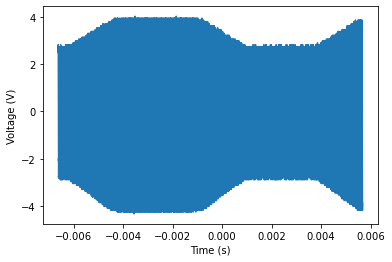

In [74]:
# plot a small segment of the data 
plt.plot(t[:300*1024], y[:300*1024])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

Text(0, 0.5, 'Voltage (V)')

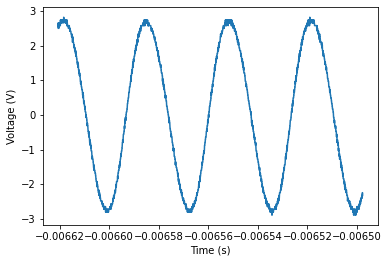

In [8]:
# zoom into the data 
plt.plot(t[:3*1024], y[:3*1024])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

### Low pass filtering

In [64]:
filter_f = 150e3
# use python to design a filter with cutoff frequnecy of 150 kHz 
# "1" represents a filter order of 1. But since sosfiltfilt applies the filter both backwards and forwards, the effective filter order doubles. 
sos = signal.butter(1, filter_f, 'lowpass', fs=fs, output='sos')
y_f = signal.sosfiltfilt(sos,  y,)

In [65]:
# use python to design a filter with cutoff frequnecy of 150 kHz 
# "1" represents a filter order of 1. But since sosfiltfilt applies the filter both backwards and forwards, the effective filter order doubles. 
sos2 = signal.butter(1, filter_f, 'lowpass', fs=fs, output='sos')
y_f_2 = signal.sosfilt(sos2,  y,)

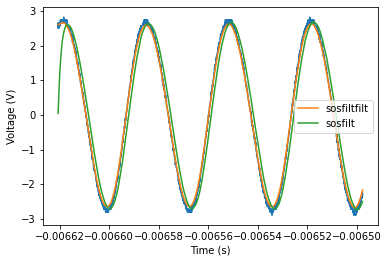

In [66]:
# compare the filtered data and the original data 
# We can plot a small segment of the data
plt.plot(t[:3*1024], y[:3*1024])
plt.plot(t[:3*1024], y_f[:3*1024], label = "sosfiltfilt")
plt.plot(t[:3*1024], y_f_2[:3*1024], label = "sosfilt")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()

In the plot above, we can clearly see the phase decay added to the signal when we only perform the filtering in a single direction. We see that in the `sosfilt` trace, digital filtering introduces an artifact into the signal. This can be removed by defining a mask. 

In [70]:
def ripple_mask(n: int, fs: float, dead_time: float):
    """Returns a mask that discards parts of the signal at the beginning and end. 

    Args:
        n (int): number of points in the data
        fs (float): sampling frequency 
        dead_time (float): the time span of any ripples 
    """
    td = dead_time
    dt = 1/fs
    
    ww = int(np.ceil((1.0*td)/(1.0*dt)))  # window width (points)
    indices = np.arange(n)
    mask = (indices >= ww) & (indices < n - ww)
    
    return mask 

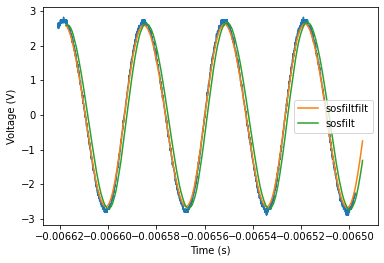

In [71]:
# we can define a mask the removes any ripples at the beginning and end of the data. 
mask = ripple_mask(len(y), fs, 80/fs)
# compare the filtered data and the original data 
# We can plot a small segment of the data
plt.plot(t[:3*1024], y[:3*1024])
plt.plot(t[mask][:3*1024], y_f[mask][:3*1024], label = "sosfiltfilt")
plt.plot(t[mask][:3*1024], y_f_2[mask][:3*1024], label = "sosfilt")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()

### Band pass filtering
To test out the capababiities of bandpass filtering, let's synthesize a signal with some normally distributed amplitude noise, and consider what happens to the signal in the frequency and time domain, before and after filtering! 

We'll synthesize a decaying sinusoid. The noise power will be 1 mV squared per hz. 

In [130]:
fd = 50.0E3    # digitization frequency [Hz]
f0 = 1E3    # signal frequency [Hz]
tau = 0.325    # decay time [s]
nt = 2.00*fd   # number of signal points (before truncation)
sn = 20.0     # signal zero-to-peak amplitude 
noise_power = 1e-3 * fd / 2

dt = 1/fd
t = dt*np.arange(nt)

noise = np.random.normal(0, np.sqrt(noise_power), t.size)

s = sn*np.sin(2*np.pi*f0*t)*np.exp(-t/tau) + noise
s_clean = sn*np.sin(2*np.pi*f0*t)*np.exp(-t/tau)


Text(0, 0.5, 'Voltage (V)')

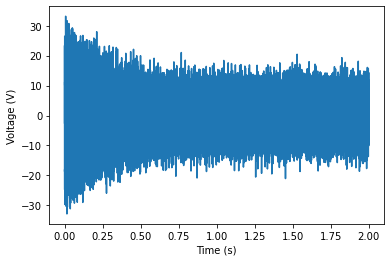

In [131]:
plt.plot(t, s)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

In the frequency domain, we can clearly see a noise floor of 1 mV squared per Hz, as we expected. 

Text(0, 0.5, 'Noise Spectral Density, $\\mathit{S}_{xx}$ (V$^{2}$/Hz)')

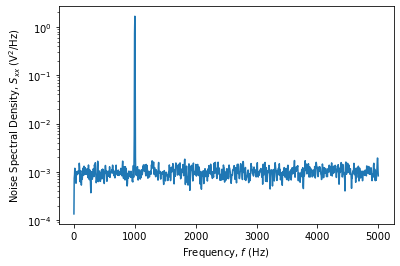

In [132]:
f, Pxx_den = signal.welch(s, fd, window=signal.windows.hann(10*1024,))
plt.semilogy(f[f<=5e3], Pxx_den[f<=5e3])
plt.xlabel("Frequency, $\mathit{f}$ (Hz)")
plt.ylabel("Noise Spectral Density, $\mathit{S}_{xx}$ (V$^{2}$/Hz)")

Let's now apply our band pass filter. The first step: 
1. Find the signal frequency 
2. Define the filter bandwidth. A smaller band width tends to underestimate the signal amplitude, were as a larger band width performs better, and allows "more noise" to remain in the signal. 

In [133]:
bw = 200
cutoffs = (f0 - bw/2, f0 + bw/2)
sos = signal.butter(1, cutoffs, btype='bandpass', output = "sos", fs = fd)

y_bp = signal.sosfiltfilt(sos, s)

Text(0, 0.5, 'Voltage (V)')

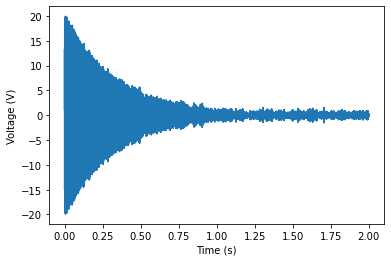

In [134]:
# how the signal looks like after filtering!
plt.plot(t, y_bp)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

We see that near the beginning of the signal, the amplitude is underestimated due to filtering artifacts. We can apply the same idea as above, and create a mask that will allow us to discard this data. 

Text(0, 0.5, 'Voltage (V)')

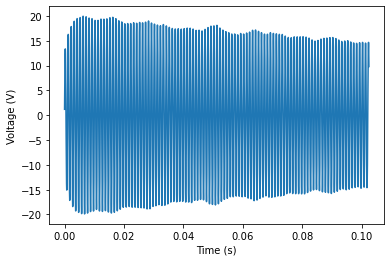

In [138]:
# how the signal looks like after filtering!
plt.plot(t[:5*1024], y_bp[:5*1024])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

Let's look at the signal in the frequency domain after filtering. We can clearly see that the signal noise floor decreased.

Text(0, 0.5, 'Noise Spectral Density, $\\mathit{S}_{xx}$ (V$^{2}$/Hz)')

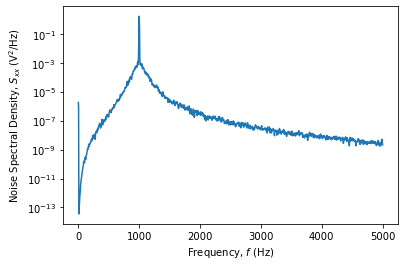

In [139]:
f, Pxx_den = signal.welch(y_bp, fd, window=signal.windows.hann(10*1024,))
plt.semilogy(f[f<=5e3], Pxx_den[f<=5e3])
plt.xlabel("Frequency, $\mathit{f}$ (Hz)")
plt.ylabel("Noise Spectral Density, $\mathit{S}_{xx}$ (V$^{2}$/Hz)")